In [1]:
import torch 
import cv2
import os

import matplotlib.pyplot as plt
import numpy as np
import random 


In [2]:
seed_number = 42

torch.manual_seed(seed_number)
np.random.seed(seed_number)
random.seed(seed_number)

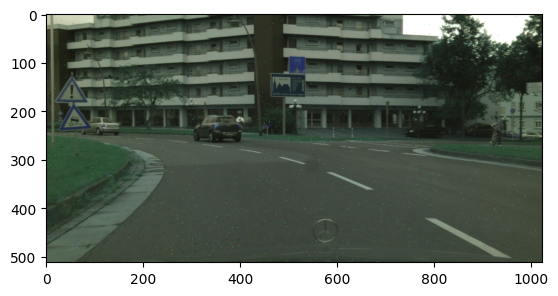

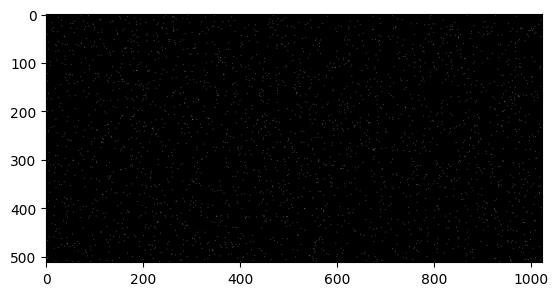

In [3]:

img = cv2.imread('./data/img_noise_pr_0_5_aachen_000000_000019_leftImg8bit.png')
gt_mask = cv2.imread('./data/gt_noise_pr_0_5_aachen_000000_000019_leftImg8bit.png')

plt.imshow(img)
plt.show()

plt.imshow(gt_mask*255, cmap='gray')
plt.show()


Show cropped image

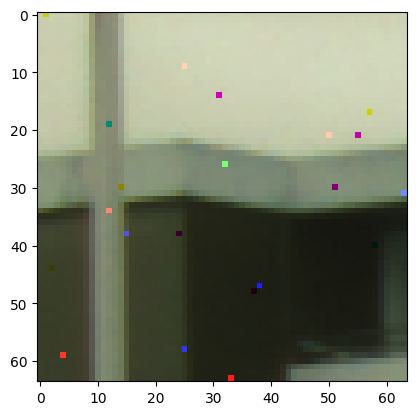

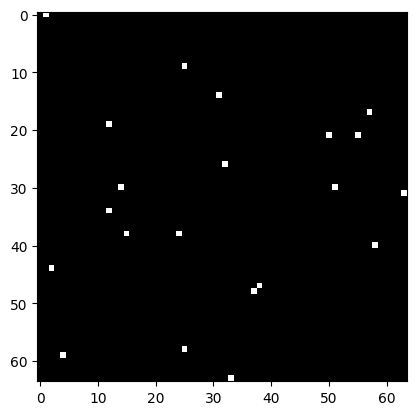

In [4]:
img_crop = img[0:64,0:64, :]
gt_mask_crop = gt_mask[0:64,0:64]

x = torch.from_numpy(img_crop.transpose(2,0,1))
msk = torch.from_numpy(gt_mask_crop)

plt.imshow(x.permute(1,2,0).numpy())
plt.show()

plt.imshow(msk.numpy()*255, cmap='gray')
plt.show()

###Masking image with mask

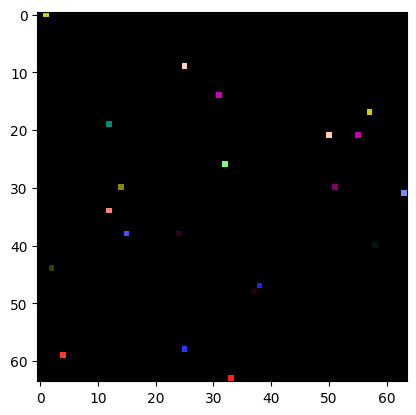

In [25]:
_msk1 = msk.permute(2,0,1)
#_msk.size(0)

masked_value_org = torch.mul(x, _msk1)

plt.imshow(masked_value_org.permute(1,2,0).numpy(), cmap='gray')
plt.show()

Apply median filter

In [5]:
# print(x.size())
# x_median = torch.median(x, keepdim=True)
# print(x_median.size())
# plt.imshow(x_median.permute(1,2,0).numpy())
# plt.show()

In [6]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple


class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module.
    
    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=0, same=False):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd, 
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

In [7]:
print(x.size())
_x = torch.unsqueeze(x, dim=0)
_x = _x.float()
#_x = F.pad(_x,(1,1,1,1),'reflect', 0)
#print(_x.size())

torch.Size([3, 64, 64])


torch.Size([3, 64, 64])


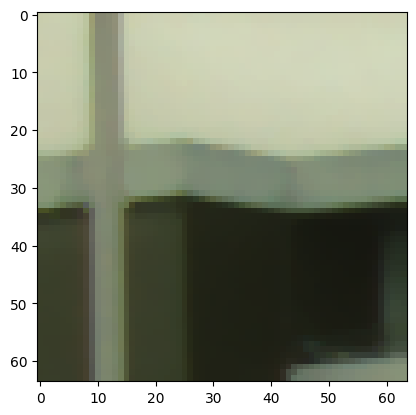

In [8]:

median_filter = MedianPool2d(same=True)

x_median = median_filter(_x)
# x_median = torch.median(x, keepdim=True)
# print(x_median.size())

_x_median = x_median.squeeze(dim=0)
print(_x_median.size())
plt.imshow(_x_median.type(torch.uint8).permute(1,2,0).numpy())
plt.show()


In [18]:
masked_value = torch.zeros_like(_x_median)

#msk.size()
_msk = msk.permute(2,0,1)

#_msk.size()
masked_value = torch.mul(_x_median, _msk)
# masked_value[1,:,:] = torch.mul(_x_median[1,:,:], msk)
# masked_value[2,:,:] = torch.mul(_x_median[2,:,:], msk)

masked_value.size()


torch.Size([3, 64, 64])

torch.Size([3, 64, 64])


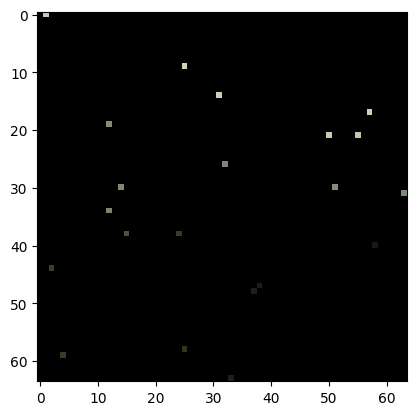

In [10]:
#_x_median = x_median.squeeze(dim=0)
print(masked_value.size())
plt.imshow(masked_value.type(torch.uint8).permute(1,2,0).numpy())
plt.show()

In [11]:
msk_inv = torch.ones_like(masked_value)

msk_inv[masked_value>0] = 0

torch.Size([3, 64, 64])


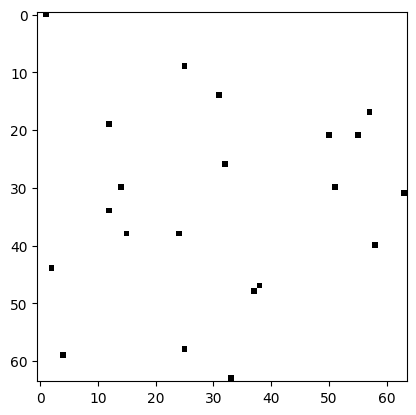

In [12]:
print(msk_inv.size())
plt.imshow(msk_inv.type(torch.uint8).permute(1,2,0).numpy()*255)
plt.show()


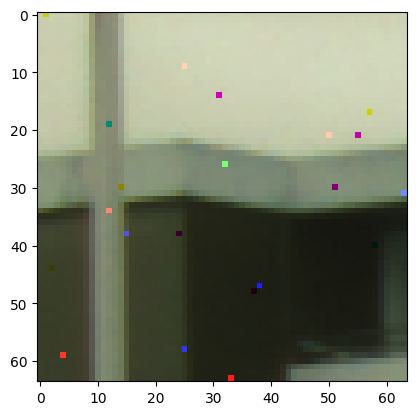

In [13]:
plt.imshow(x.permute(1,2,0).numpy())
plt.show()

In [14]:
y = (torch.mul(x,msk_inv) + masked_value).type(torch.uint8)

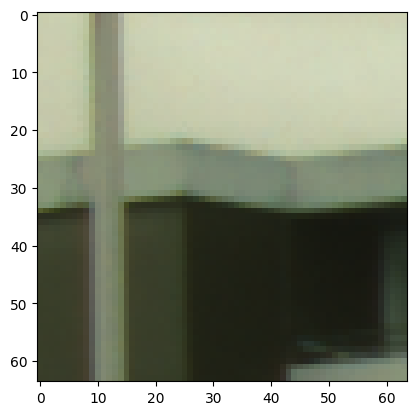

In [15]:
plt.imshow(y.permute(1,2,0).numpy())
plt.show()